Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

# Domain Threat Interpretability

This notebook focuses on interpretability for three malicious domain classes—DGA, malware and phishing—across four data modalities:  
- raw domain names  
- RDAP records  
- DNS records  
- geolocation metadata  

Each section loads a fine-tuned Transformer model, computes Integrated Gradients attributions for the “benign” class, and visualizes the top token contributions for insight into model decisions.  

# Domain names

In [1]:
DGA_MODEL_NAME = "prajjwal1/bert-medium"
MALWARE_MODEL_NAME = "google/electra-base-discriminator"
PHISHING_MODEL_NAME = "distilbert-base-uncased"

## DGA

/home/fetagpu/miniconda3/envs/igpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/1389275386.py:104: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


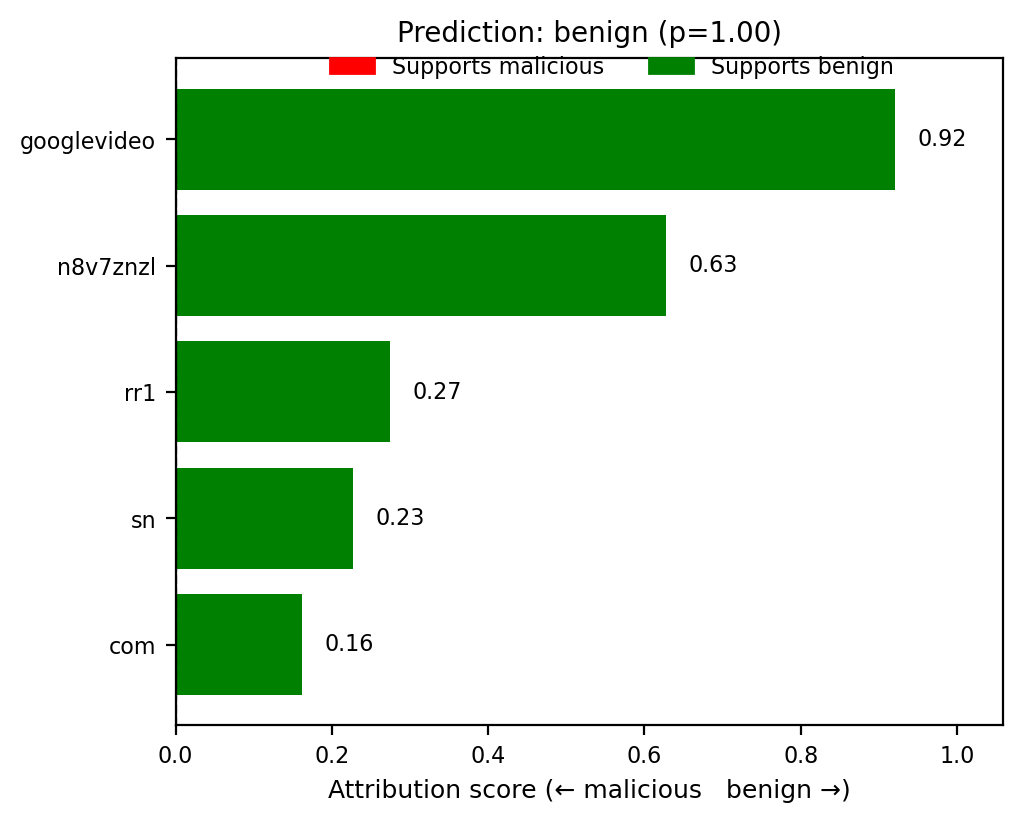

In [2]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# Global font settings
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

# Model and tokenizer setup
MODEL_CHECKPOINT = "../models/domain/BEST_dga_prajjwal1-bert-medium_20250503_145342.pt"
DGA_MODEL_NAME = "prajjwal1/bert-medium"

tokenizer = AutoTokenizer.from_pretrained(DGA_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(DGA_MODEL_NAME, num_labels=2)

# Load fine-tuned weights and switch to evaluation mode
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()

# Prepare a DNS record (or any input string) for attribution
record = "rr1---sn-n8v7znzl.googlevideo.com"
inputs = tokenizer(record, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Run the model to get prediction and confidence
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

# Set up Integrated Gradients to attribute the "benign" logit (index 0)
embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

# Convert attributions to token-level scores
token_scores = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Merge subword tokens and filter out punctuation/special tokens
words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)

# Aggregate duplicate words and drop single-character entries
aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

# Select top K tokens by absolute attribution score
K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

# Plot horizontal bar chart of attributions
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)
ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})")

# Add legend for color mapping
red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/2711897712.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


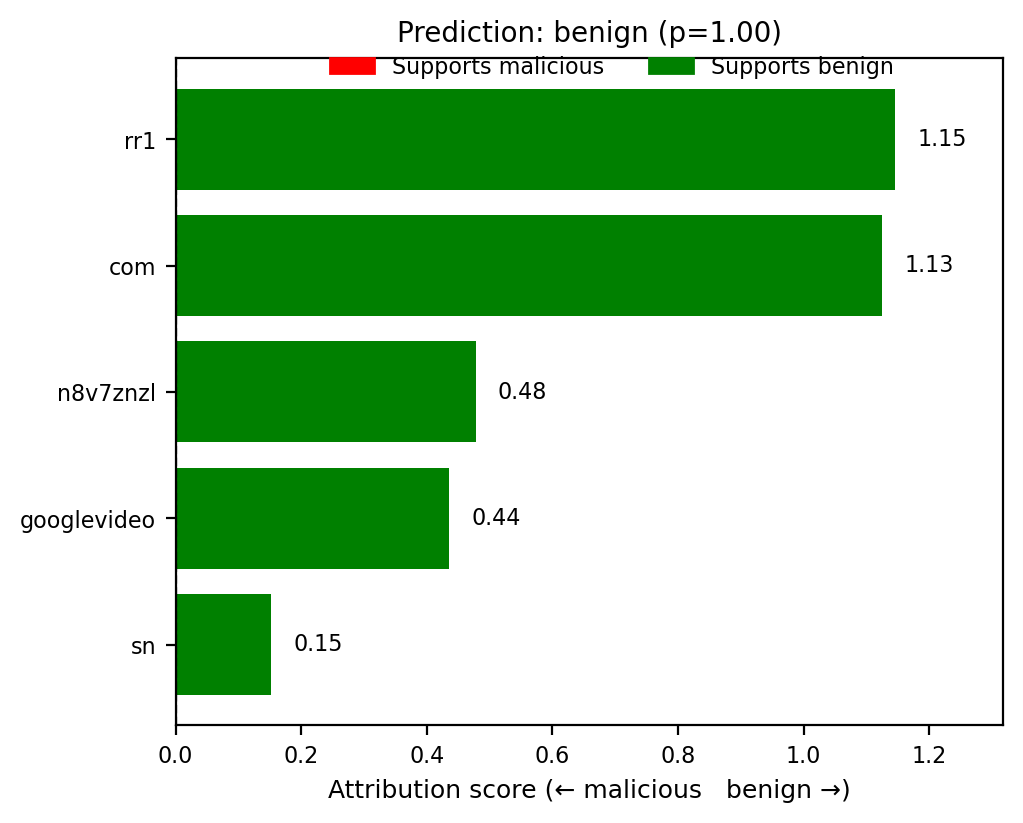

In [ ]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# Global font settings
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

# Model and tokenizer setup
MODEL_CHECKPOINT = "../models/domain/BEST_malware_google-electra-base-discriminator_20250504_001819.pt"

tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MALWARE_MODEL_NAME, num_labels=2)

# Load fine-tuned weights and switch to evaluation mode
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()

# Prepare a DNS record (or any input string) for attribution
record = "rr1---sn-n8v7znzl.googlevideo.com"
inputs = tokenizer(record, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Run the model to get prediction and confidence
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

# Set up Integrated Gradients to attribute the "benign" logit (index 0)
embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

# Convert attributions to token-level scores
token_scores = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Merge subword tokens and filter out punctuation/special tokens
words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)

# Aggregate duplicate words and drop single-character entries
aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

# Select top K tokens by absolute attribution score
K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

# Plot horizontal bar chart of attributions
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)
ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})")

# Add legend for color mapping
red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/4166963241.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


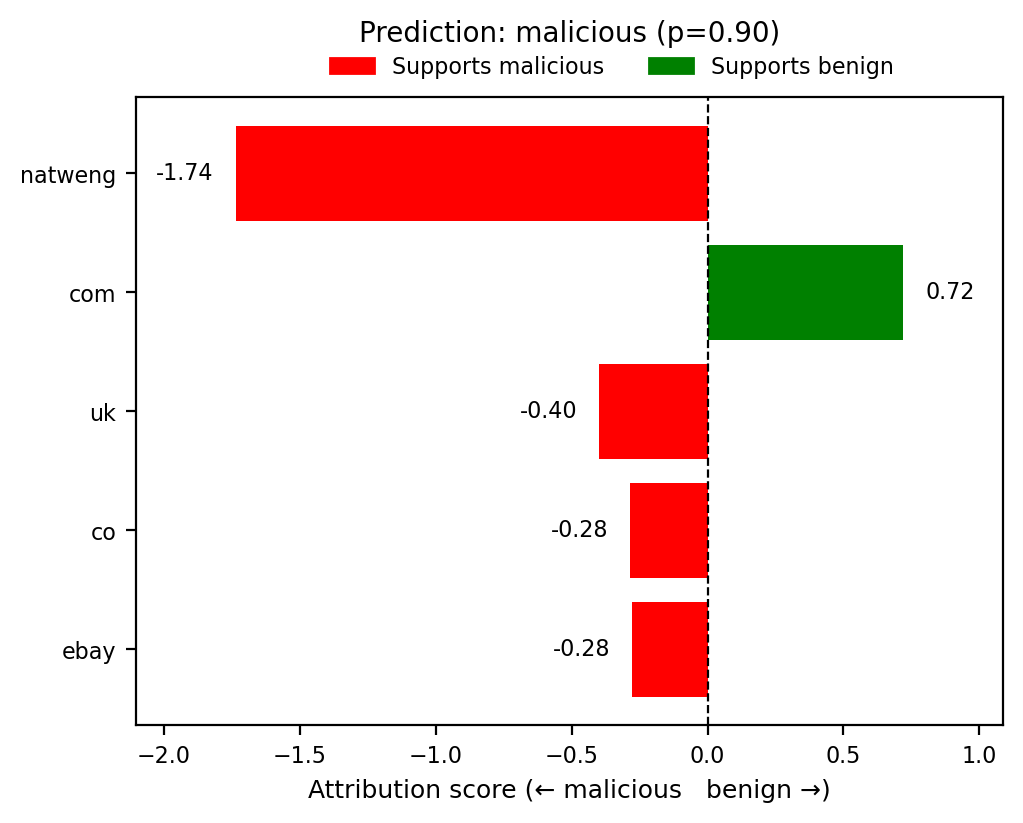

In [8]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

# Global font settings
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

# Model and tokenizer setup
MODEL_CHECKPOINT = "../models/domain/BEST_malware_google-electra-base-discriminator_20250504_001819.pt"

tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MALWARE_MODEL_NAME, num_labels=2)

# Load fine-tuned weights and switch to evaluation mode
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()

# Prepare a DNS record (or any input string) for attribution
record = "ebay.co.uk.natweng.com"
inputs = tokenizer(record, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Run the model to get prediction and confidence
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

# Set up Integrated Gradients to attribute the "benign" logit (index 0)
embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

# Convert attributions to token-level scores
token_scores = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Merge subword tokens and filter out punctuation/special tokens
words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)

# Aggregate duplicate words and drop single-character entries
aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

# Select top K tokens by absolute attribution score
K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

# Plot horizontal bar chart of attributions
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)
ax.invert_yaxis()
ax.axvline(0, color="black", linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

# Add legend for color mapping
red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/2303078223.py:124: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


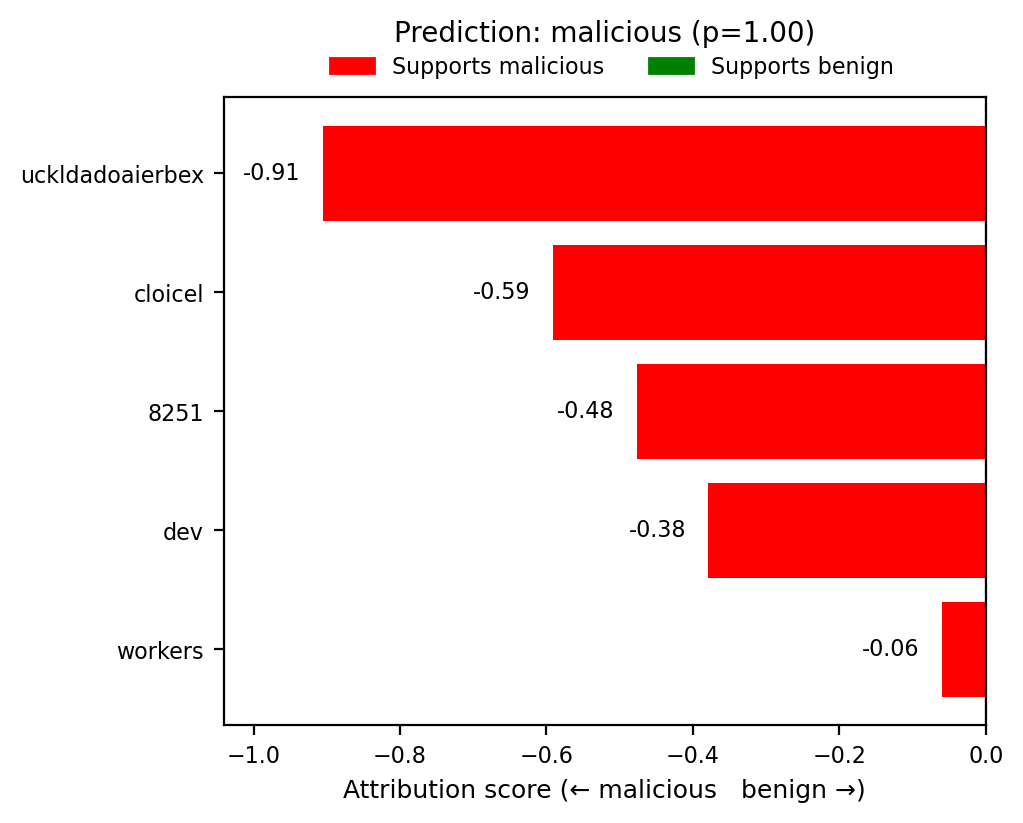

In [ ]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients


# Global font settings
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})


# Model and tokenizer setup
MODEL_CHECKPOINT = "../models/domain/BEST_phish_distilbert-base-uncased_20250504_014049.pt"

tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)

# Load fine-tuned weights and switch to evaluation mode
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()


# Prepare input string for attribution
record = ("cloicel-8251.uckldadoaierbex.workers.dev")

inputs = tokenizer(record, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]


# Run model to get prediction and confidence
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])


# Set up Integrated Gradients targeting the "benign" logit (index 0)
embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)


def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]


ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)


# Convert attributions to token-level scores
token_scores = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())


# Merge subword tokens and filter out special chars
words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)


# Aggregate duplicates and drop single-character entries
aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())


# Select top K tokens by absolute attribution score
K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]


# Plot horizontal bar chart of attributions
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})",pad=20)

# Legend for color mapping
red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/1309074089.py:124: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


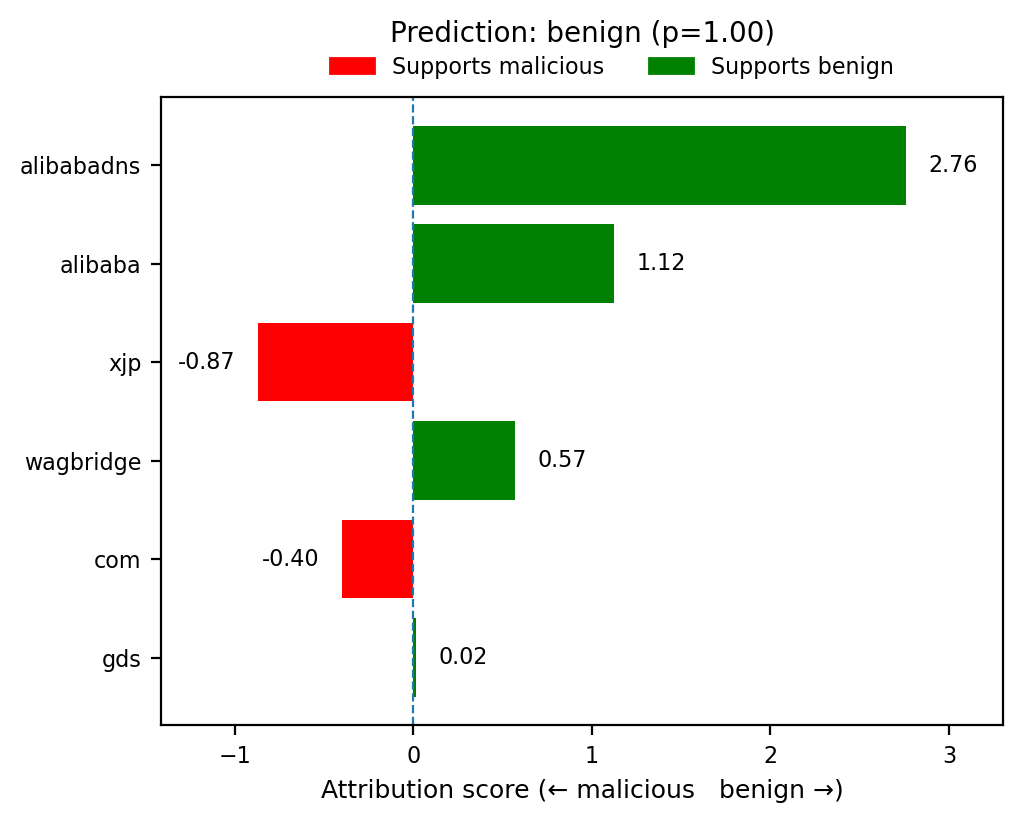

In [12]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients


# Global font settings
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})


# Model and tokenizer setup
MODEL_CHECKPOINT = "../models/domain/BEST_phish_distilbert-base-uncased_20250504_014049.pt"

tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PHISHING_MODEL_NAME, num_labels=2
)

# Load fine-tuned weights and switch to evaluation mode
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()


# Prepare input string for attribution
record = ("xjp.wagbridge.alibaba.com.gds.alibabadns.com")

inputs = tokenizer(record, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]


# Run model to get prediction and confidence
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])


# Set up Integrated Gradients targeting the "benign" logit (index 0)
embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)


def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]


ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)


# Convert attributions to token-level scores
token_scores = (
    attributions.sum(dim=-1)
                .squeeze(0)
                .detach()
                .cpu()
                .numpy()
)
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())


# Merge subword tokens and filter out special chars
words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)


# Aggregate duplicates and drop single-character entries
aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())


# Select top K tokens by absolute attribution score
K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]


# Plot horizontal bar chart of attributions
fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})",pad=20)

# Legend for color mapping
red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


# RDAP

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/3935888959.py:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


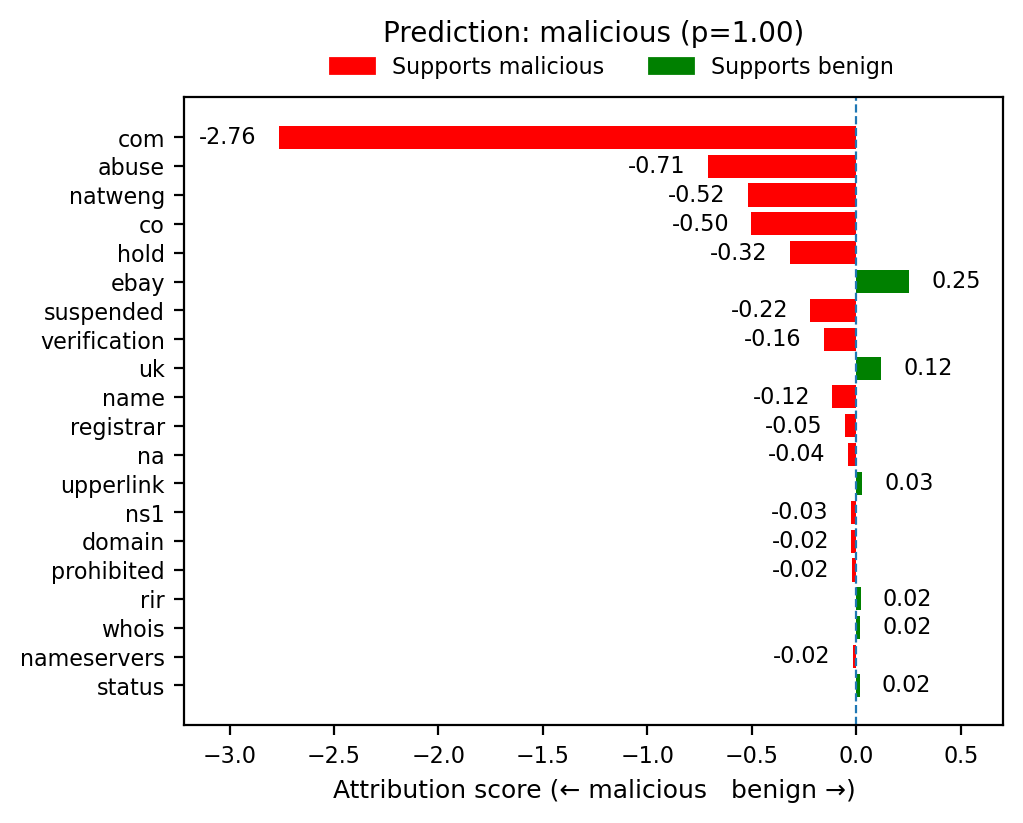

In [14]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

MODEL_CHECKPOINT = "../models/rdap/malware_electra-base-discriminator_20250512_174759_BEST.pt"
tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MALWARE_MODEL_NAME, num_labels=2)
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location="cpu"))
model.eval()

record = (
    "[CLS] domain: ebay.co.uk.natweng.com [SEP] "
    "abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] "
    "registrar: name: Upperlink Limited | email: NA | whois_server: NA | url: NA | "
    "tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | "
    "whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] "
    "admin: NA [SEP] nameservers: NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM, "
    "NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM [SEP] status: client transfer prohibited [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_lbl = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, sc in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens:
        continue
    if re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += sc
    else:
        words.append(tok)
        scores.append(sc)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_lbl} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/2650970500.py:99: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


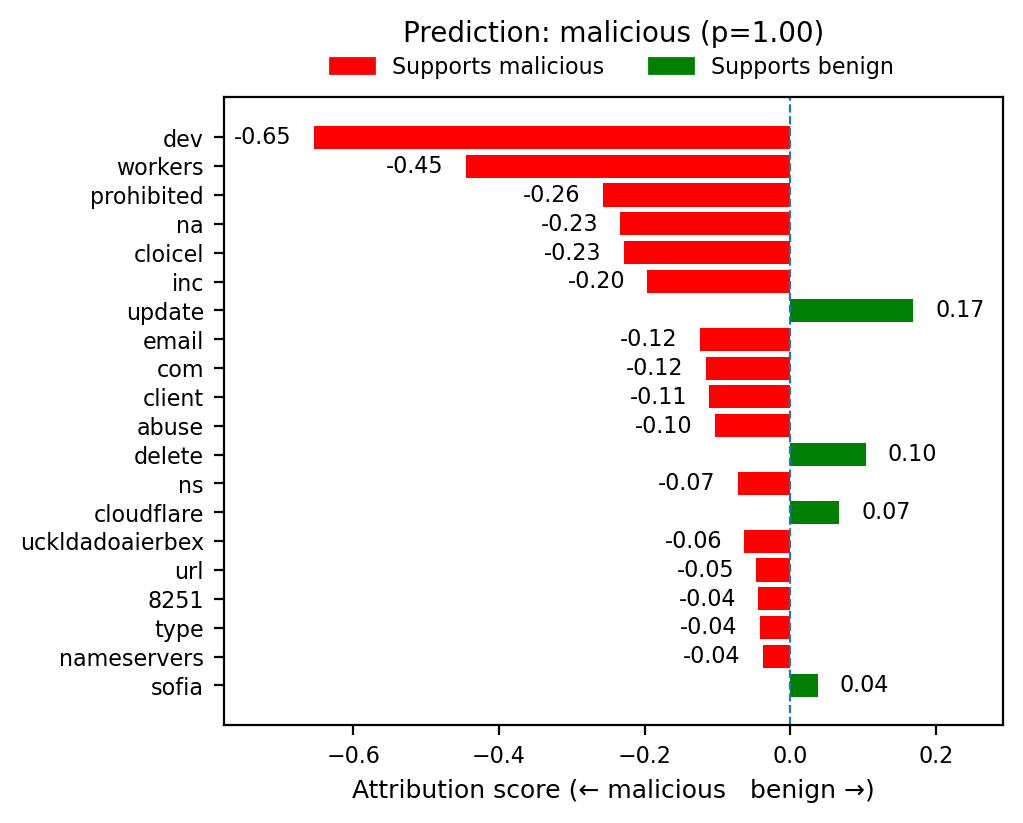

In [15]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

PHISHING_MODEL_NAME = "distilbert-base-uncased"
MODEL_CHECKPOINT = "../models/rdap/phishing_distilbert-base-uncased_20250512_201957_BEST.pt"

tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(PHISHING_MODEL_NAME, num_labels=2)
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

record = (
    "[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] "
    "abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] "
    "registrar: name: CloudFlare, Inc. | email: NA | whois_server: NA | url: NA | "
    "tel: NA | handle: NA | type: NA [SEP] registrant: name: DATA REDACTED | email: NA | "
    "whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] "
    "admin: name: NA | email: NA | handle: NA | type: NA [SEP] "
    "nameservers: CLYDE.NS.CLOUDFLARE.COM, SOFIA.NS.CLOUDFLARE.COM [SEP] "
    "status: client delete prohibited, client transfer prohibited, client update prohibited [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, score in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens or re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += score
    else:
        words.append(tok)
        scores.append(score)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


# DNS

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/2653121050.py:97: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


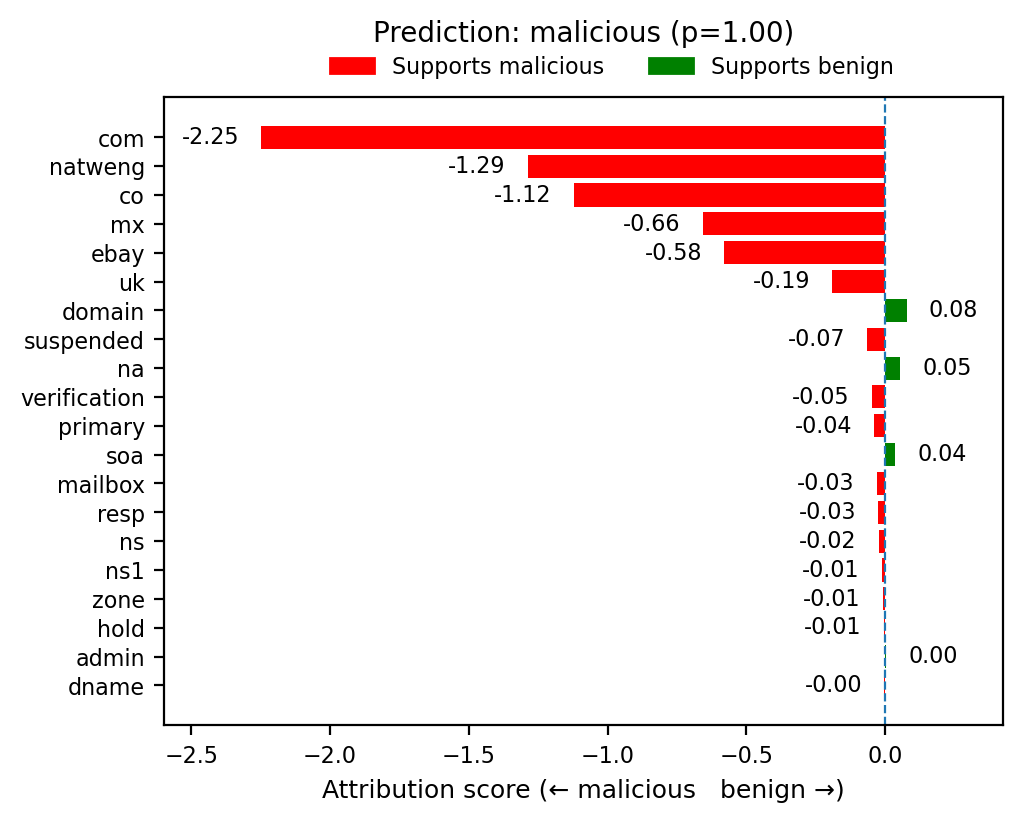

In [16]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

MALWARE_MODEL_NAME = "google/electra-base-discriminator"
MODEL_CHECKPOINT = "../models/dns/malware_electra-base-discriminator_20250512_220139_BEST.pt"

tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MALWARE_MODEL_NAME, num_labels=2)
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

record = (
    "[CLS] domain: ebay.co.uk.natweng.com [SEP] "
    "MX: NA [SEP] NS: NA [SEP] "
    "SOA: primary_ns: ns1.verification-hold.suspended-domain.com | "
    "resp_mailbox_dname: admin.suspended-domain.com [SEP] "
    "zone_SOA: NA [SEP] "
    "remarks: zone: ebay.co.uk.natweng.com [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, score in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens or re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += score
    else:
        words.append(tok)
        scores.append(score)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/944364243.py:95: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


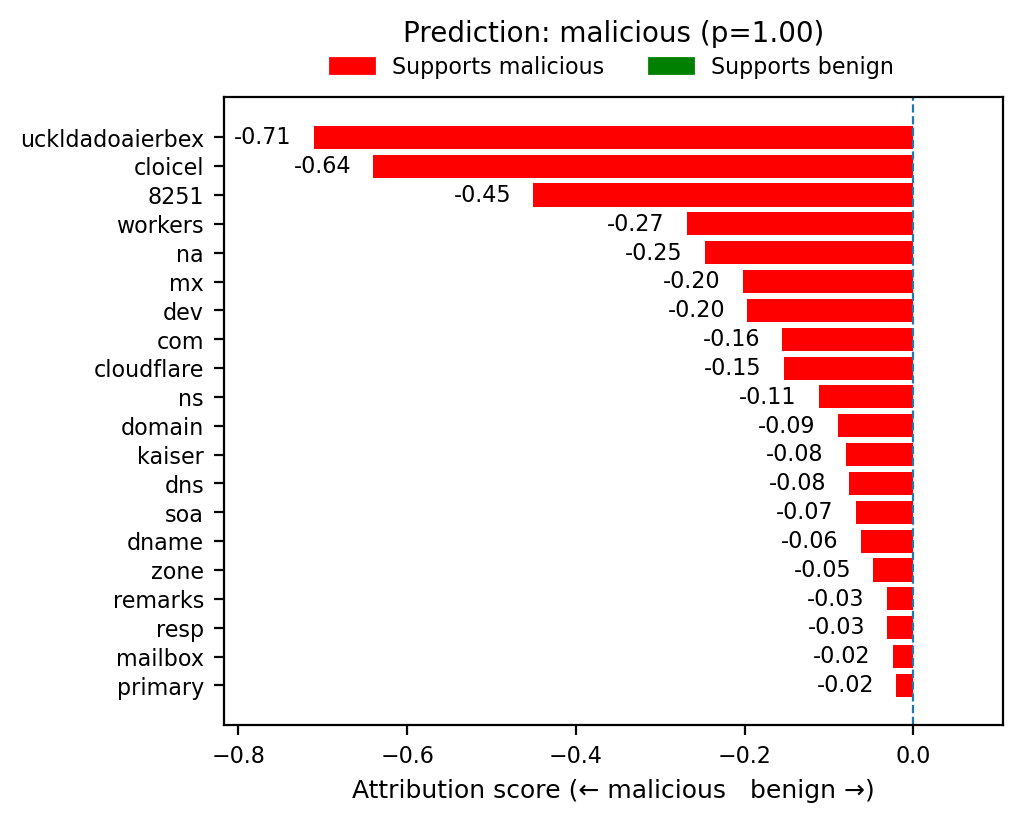

In [17]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

PHISHING_MODEL_NAME = "distilbert-base-uncased"
MODEL_CHECKPOINT = "../models/dns/phishing_distilbert-base-uncased_20250512_233838_BEST.pt"

tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(PHISHING_MODEL_NAME, num_labels=2)
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

record = (
    "[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] "
    "MX: NA [SEP] NS: NA [SEP] SOA: NA [SEP] "
    "zone_SOA: primary_ns: kaiser.ns.cloudflare.com | resp_mailbox_dname: dns.cloudflare.com [SEP] "
    "remarks: zone: uckldadoaierbex.workers.dev [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, score in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens or re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += score
    else:
        words.append(tok)
        scores.append(score)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


# GEO

## Malware

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/546625.py:94: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


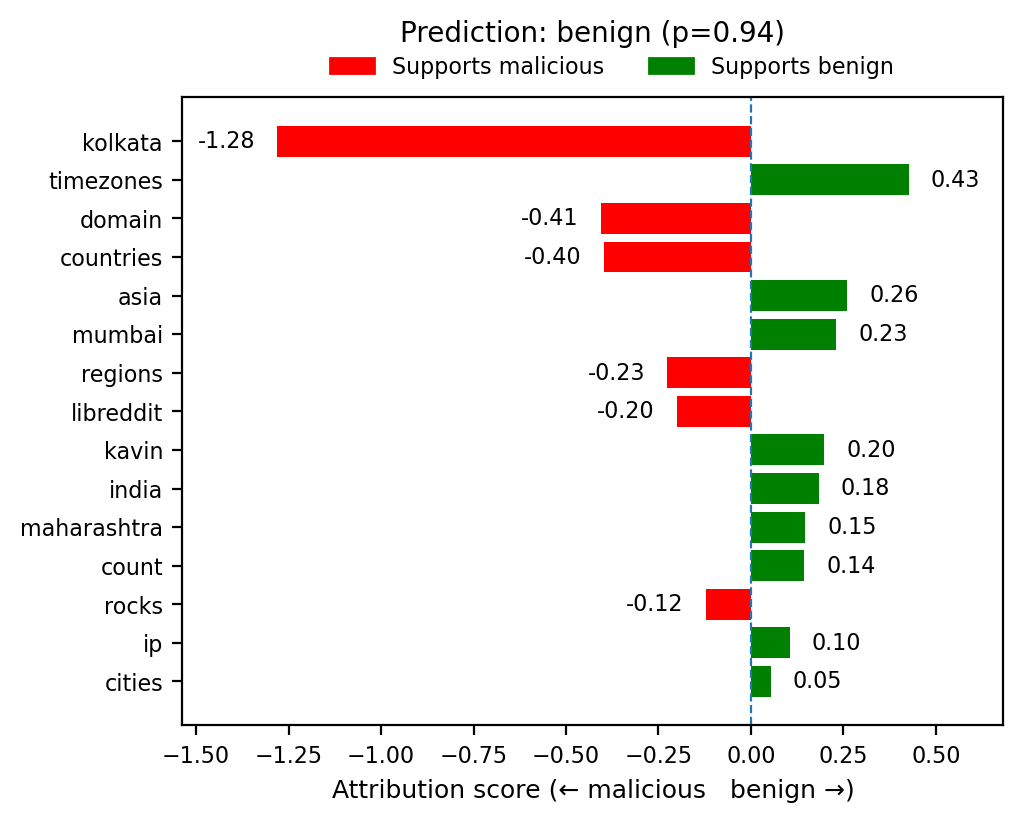

In [18]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

MALWARE_MODEL_NAME = "google/electra-base-discriminator"
MODEL_CHECKPOINT = "../models/geo/malware_electra-base-discriminator_20250513_010704_BEST.pt"

tokenizer = AutoTokenizer.from_pretrained(MALWARE_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MALWARE_MODEL_NAME, num_labels=2)
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

record = (
    "[CLS] domain: libreddit.kavin.rocks [SEP] "
    "ip_count: 2 [SEP] countries: India [SEP] regions: Maharashtra [SEP] "
    "cities: Mumbai [SEP] timezones: Asia/Kolkata [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, score in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens or re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += score
    else:
        words.append(tok)
        scores.append(score)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()


## Phishing

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_287004/1469654143.py:94: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.5)


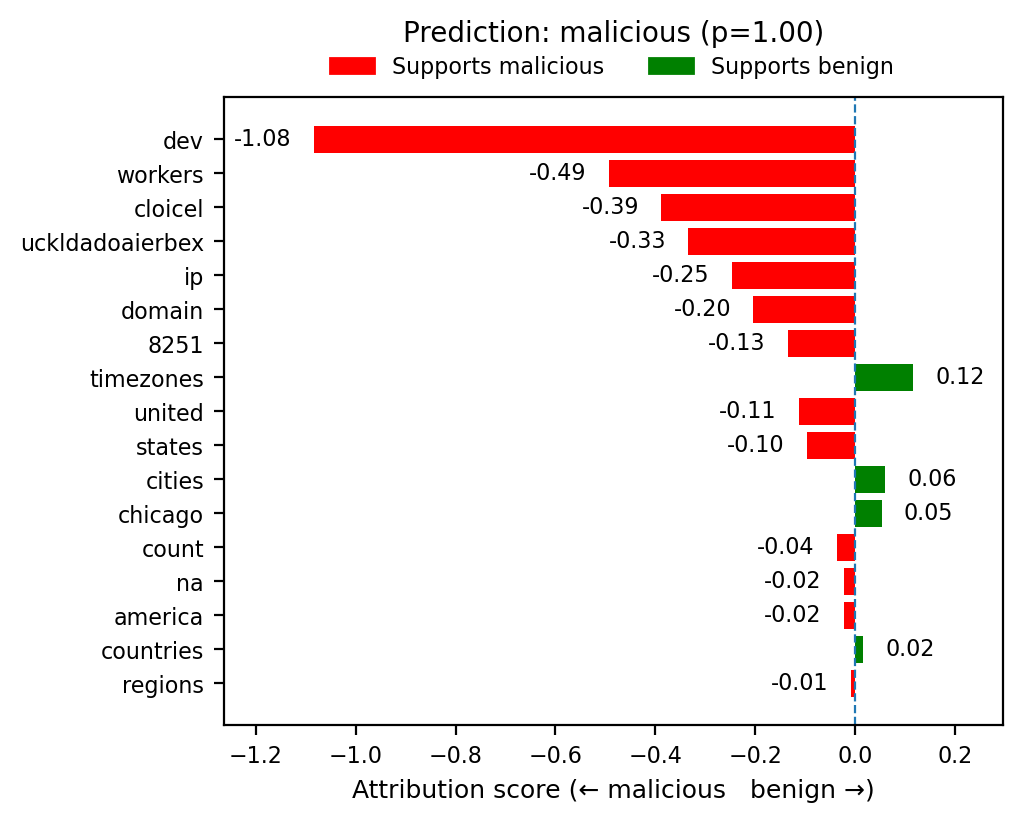

In [19]:
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.patches as mpatches

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients

plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
})

PHISHING_MODEL_NAME = "distilbert-base-uncased"
MODEL_CHECKPOINT = "../models/geo/phishing_distilbert-base-uncased_20250513_013233_BEST.pt"

tokenizer = AutoTokenizer.from_pretrained(PHISHING_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(PHISHING_MODEL_NAME, num_labels=2)
state_dict = torch.load(MODEL_CHECKPOINT, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

record = (
    "[CLS] domain: cloicel-8251.uckldadoaierbex.workers.dev [SEP] "
    "ip_count: 4 [SEP] countries: United States [SEP] regions: NA [SEP] "
    "cities: NA [SEP] timezones: America/Chicago [SEP]"
)
enc = tokenizer(record, return_tensors="pt")
input_ids = enc["input_ids"]
attention_mask = enc["attention_mask"]

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask).logits
    probs = torch.softmax(logits, dim=1)[0]
    pred_idx = int(probs.argmax())
    labels = ["benign", "malicious"]
    pred_label = labels[pred_idx]
    pred_conf = float(probs[pred_idx])

embeddings = model.get_input_embeddings()(input_ids).requires_grad_(True)
baseline = torch.zeros_like(embeddings)

def forward_benign(inputs_embeds, mask):
    return model(inputs_embeds=inputs_embeds, attention_mask=mask).logits[:, 0]

ig = IntegratedGradients(forward_benign)
attributions = ig.attribute(
    embeddings,
    baselines=baseline,
    additional_forward_args=(attention_mask,),
    n_steps=50
)

token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

words, scores = [], []
for tok, score in zip(tokens, token_scores):
    if tok in tokenizer.all_special_tokens or re.fullmatch(r"[^\w]+", tok):
        continue
    if tok.startswith("##"):
        words[-1] += tok[2:]
        scores[-1] += score
    else:
        words.append(tok)
        scores.append(score)

aggregated = OrderedDict()
for w, s in zip(words, scores):
    aggregated[w] = aggregated.get(w, 0.0) + s

filtered = [(w, s) for w, s in aggregated.items() if len(w) > 1]
if filtered:
    words, scores = zip(*filtered)
else:
    words, scores = list(aggregated.keys()), list(aggregated.values())

K = 20
indices = np.argsort(np.abs(scores))[::-1][:K]
top_words = [words[i] for i in indices]
top_scores = [scores[i] for i in indices]

fig, ax = plt.subplots(
    figsize=(5.0, max(4, len(top_words) * 0.2)),
    dpi=200,
    constrained_layout=True
)
plt.subplots_adjust(left=0.5)

colors = ["green" if s > 0 else "red" for s in top_scores]
bars = ax.barh(top_words, top_scores, color=colors)

ax.invert_yaxis()
ax.axvline(0, linestyle="--", linewidth=0.8)
ax.bar_label(bars, fmt="%.2f", padding=8, label_type="edge")
ax.margins(x=0.15)
ax.set_xlabel("Attribution score (← malicious   benign →)")
ax.set_title(f"Prediction: {pred_label} (p={pred_conf:.2f})", pad=20)

red_patch = mpatches.Patch(color="red", label="Supports malicious")
green_patch = mpatches.Patch(color="green", label="Supports benign")
fig.legend(
    handles=[red_patch, green_patch],
    loc="upper center",
    bbox_to_anchor=(0.6, 0.97),
    ncol=2,
    frameon=False
)

plt.show()
